## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics.dataquality import calculate_data_quality_metrics, calculate_average_metrics

from metrics.overallscore import calculate_overall_score
from metrics.overallscore import calculate_overall_score_mom

from metrics.feature_calculations import calculate_unique_meter_count
from metrics.feature_calculations import calculate_metrics_by_month

from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [2]:
data = pd.read_csv("data/yedc/yedc_caims_data.csv")

In [3]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [4]:
filtered_data_ecg = data_x[data_x['SLRN'].str.startswith('YEDC')]

In [5]:
df = filtered_data_ecg.copy()

In [6]:
df.dtypes

SLRN                        object
Account Number             float64
Date                        object
Meter Number                object
Meter SLRN                  object
Meter Status                object
region                      object
district                    object
Phone Number               float64
Email                       object
assigned_user               object
First Captured Username     object
Updated Username            object
last_update_date            object
Customer Status             object
dtype: object

## METRICS

In [7]:
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number']:
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Phone Number':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Email':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = df['Meter Number'].count()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 6,220

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 100.00%
Integrity: 98.44%
Overall Score: 99.60

Metrics for Account Number:
Completeness: 98.26%
Validity: 98.20%
Integrity: 82.00%
Overall Score: 94.80

Metrics for Meter Number:
Completeness: 82.20%
Validity: 82.19%
Integrity: 82.19%
Overall Score: 82.00

Metrics for Phone Number:
Completeness: 88.90%
Validity: 88.89%
Integrity: 73.04%
Overall Score: 85.20

Metrics for Email:
Completeness: 37.28%
Validity: 37.11%
Integrity: 29.39%
Overall Score: 36.40

Quality Metrics - Average and Overall Score:
Average Completeness: 81.33%
Average Validity: 81.28%
Average Integrity: 73.01%
Overall Score: 80.40


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [9]:
# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

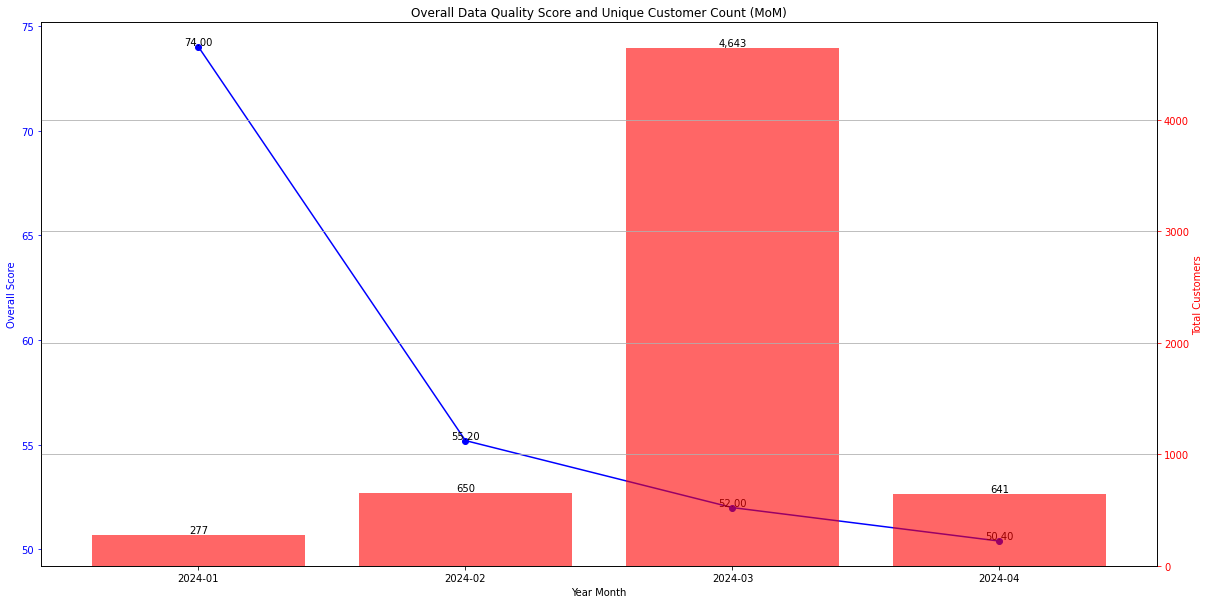

In [10]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.show()


In [ ]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('data/exports/mom_overall_score_dec_2023.csv', index=False)

### CALCULATE METRICS BY MONTH

In [11]:
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

mom_data_quality_metrics = calculate_metrics_by_month(
    df, 
    key_fields, 
    bd_slrn='YEDCBD', 
    bdslrn_len=13, 
)

TypeError: calculate_metrics_by_month() missing 2 required positional arguments: 'meter_slrn' and 'mslrn_len'

In [14]:
mom_data_quality_metrics

,Year Month,Key fields,Completeness,Validity,Integrity,Overall Score,Unique Meter Count
99,2024-01,Meter SLRN,99.916430,99.916430,99.916430,74.0,66808
101,2024-01,Email,0.583495,0.583495,0.583495,74.0,66808
96,2024-01,SLRN,100.000000,99.998508,99.919415,74.0,66808
97,2024-01,Account Number,71.651992,71.651992,71.635577,74.0,66808
98,2024-01,Meter Number,99.923892,99.898523,100.000000,74.0,66808
...,...,...,...,...,...,...,...
12,2022-08,SLRN,100.000000,99.990402,100.000000,86.0,10223
17,2022-08,Email,62.846722,22.055859,1.650830,86.0,10223
16,2022-08,Phone Number,96.995873,89.634322,76.312506,86.0,10223
15,2022-08,Meter SLRN,97.725310,97.235819,97.725310,86.0,10223


In [15]:
mom_data_quality_metrics.to_csv('data/exports/mom_metrics.csv', index=False)

In [ ]:
jan_df = df[df['Date'] > '2023-12-31']
dec_df = df[df['year_month'] == 202312]

In [ ]:
dec_df.to_csv('dec_df.csv', index=False)

## QUALITY SCORE BY DATA COLLECTOR

In [ ]:
df_x = df[df['year_month'] >= 202311]

field_metrics = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

collector_scores = calculate_quality_score_by_collector(df_x, field_metrics)

collector_scores


,Average Completeness,Average Validity,Average Integrity,Overall Average
RolandA,40.00%,40.00%,40.00%,40.00%
AsieduS,40.00%,40.00%,40.00%,40.00%
CharlesA,37.78%,37.78%,36.67%,37.41%
Abugaemmanuel,36.67%,36.67%,36.67%,36.67%
ErnestKabu,36.88%,36.60%,36.28%,36.59%
...,...,...,...,...
StephanieOwusu,24.71%,24.00%,21.18%,23.29%
EnochOsei,24.03%,23.53%,21.55%,23.04%
JenniferNdinga,23.05%,22.92%,22.79%,22.92%
PeterBernasko,21.25%,21.17%,20.83%,21.08%


In [ ]:
collector_scores.to_csv('data/exports/collectors_score_dec_2023.csv', index=True)